In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms   # <-- REQUIRED
from PIL import Image
import pandas as pd
import os


In [2]:
import os
import pandas as pd

root = "/kaggle/input/face-morph-dsp/FEI_preprocessed/FEI_preprocessed"

bonafide_dir = os.path.join(root, "bonafide")
morph_dir = os.path.join(root, "morphed")

# Allowed bonafide identity folders
valid_ids = {"5", "6", "11", "12", "13"}

bonafide_rows = []
morph_rows = []

# ----------------------------------------------------------
# PROCESS BONAFIDE (label = 0)
# ----------------------------------------------------------
for fname in os.listdir(bonafide_dir):
    if not fname.lower().endswith(".jpg"):
        continue
    
    # Extract identity: the part before '-'
    identity = fname.split("-")[0]
    
    if identity in valid_ids:
        bonafide_rows.append({
            "path": os.path.join(bonafide_dir, fname),
            "label": 0
        })

# ----------------------------------------------------------
# PROCESS ALL MORPH FILES (label = 1)
# ----------------------------------------------------------
for fname in os.listdir(morph_dir):
    if not fname.lower().endswith(".jpg"):
        continue
    
    morph_rows.append({
        "path": os.path.join(morph_dir, fname),
        "label": 1
    })

# Convert to DataFrames
bonafide_df = pd.DataFrame(bonafide_rows)
morph_df = pd.DataFrame(morph_rows)

# Optional: merge into 1 file
final_df = pd.concat([bonafide_df, morph_df], ignore_index=True)
final_df.to_csv("/kaggle/working/FEI_smad_final.csv", index=False)

bonafide_df.head(), morph_df.head(), final_df.head()


(                                                path  label
 0  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      0
 1  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      0
 2  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      0
 3  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      0
 4  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      0,
                                                 path  label
 0  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      1
 1  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      1
 2  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      1
 3  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      1
 4  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      1,
                                                 path  label
 0  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      0
 1  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      0
 2  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      0
 3  /kaggle/input/face

In [3]:
import os
import pandas as pd

root = "/kaggle/input/face-morph-dsp/FRLL_preprocessed/FRLL_preprocessed"

bonafide_dir = os.path.join(root, "bonafide")
morph_dir = os.path.join(root, "morphed")

bonafide_rows = []
morph_rows = []

# ----------------------------------------------------------
# PROCESS BONAFIDE (label = 0)
# ----------------------------------------------------------
for fname in os.listdir(bonafide_dir):
    if fname.lower().endswith(".jpg"):
        bonafide_rows.append({
            "path": os.path.join(bonafide_dir, fname),
            "label": 0
        })

# ----------------------------------------------------------
# PROCESS MORPH (label = 1)
# ----------------------------------------------------------
for fname in os.listdir(morph_dir):
    if fname.lower().endswith(".jpg"):
        morph_rows.append({
            "path": os.path.join(morph_dir, fname),
            "label": 1
        })

# Convert to DataFrames
bonafide_df = pd.DataFrame(bonafide_rows)
morph_df = pd.DataFrame(morph_rows)

# Save separate CSVs
bonafide_df.to_csv("/kaggle/working/FRLL_bonafide_smad.csv", index=False)
morph_df.to_csv("/kaggle/working/FRLL_morph_smad.csv", index=False)

# Combined final dataset
final_df = pd.concat([bonafide_df, morph_df], ignore_index=True)
final_df.to_csv("/kaggle/working/FRLL_smad_final.csv", index=False)

bonafide_df.head(), morph_df.head(), final_df.head()


(                                                path  label
 0  /kaggle/input/face-morph-dsp/FRLL_preprocessed...      0
 1  /kaggle/input/face-morph-dsp/FRLL_preprocessed...      0
 2  /kaggle/input/face-morph-dsp/FRLL_preprocessed...      0
 3  /kaggle/input/face-morph-dsp/FRLL_preprocessed...      0
 4  /kaggle/input/face-morph-dsp/FRLL_preprocessed...      0,
                                                 path  label
 0  /kaggle/input/face-morph-dsp/FRLL_preprocessed...      1
 1  /kaggle/input/face-morph-dsp/FRLL_preprocessed...      1
 2  /kaggle/input/face-morph-dsp/FRLL_preprocessed...      1
 3  /kaggle/input/face-morph-dsp/FRLL_preprocessed...      1
 4  /kaggle/input/face-morph-dsp/FRLL_preprocessed...      1,
                                                 path  label
 0  /kaggle/input/face-morph-dsp/FRLL_preprocessed...      0
 1  /kaggle/input/face-morph-dsp/FRLL_preprocessed...      0
 2  /kaggle/input/face-morph-dsp/FRLL_preprocessed...      0
 3  /kaggle/input/face

In [4]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# ----------------------------
# Helper: Extract identity
# ----------------------------
def extract_identity(fname):
    base = fname.split(".")[0]
    if "_" in base:   # FRLL morph e.g. 001_002
        return base.split("_")[0]
    if "-" in base:   # FEI e.g. 5-01
        return base.split("-")[0]
    return base       # FRLL bonafide

# ----------------------------
# Load FEI + FRLL CSV created earlier
# ----------------------------
fei_df = pd.read_csv("/kaggle/working/FEI_smad_final.csv")
frll_df = pd.read_csv("/kaggle/working/FRLL_smad_final.csv")

# Combine all
df = pd.concat([fei_df, frll_df], ignore_index=True)

# Add identity column
df["identity"] = df["path"].apply(lambda x: extract_identity(os.path.basename(x)))

# ----------------------------
# Group by identity
# ----------------------------
identities = df["identity"].unique()

# Split identities (NOT images)
train_ids, temp_ids = train_test_split(identities, test_size=0.3, random_state=42)
val_ids, test_ids   = train_test_split(temp_ids, test_size=0.5, random_state=42)

# ----------------------------
# Assign split based on identity
# ----------------------------
train_df = df[df["identity"].isin(train_ids)]
val_df   = df[df["identity"].isin(val_ids)]
test_df  = df[df["identity"].isin(test_ids)]

# ----------------------------
# Save CSVs
# ----------------------------
train_df.to_csv("/kaggle/working/SMAD_train.csv", index=False)
val_df.to_csv("/kaggle/working/SMAD_val.csv", index=False)
test_df.to_csv("/kaggle/working/SMAD_test.csv", index=False)

train_df.head(), val_df.head(), test_df.head()


(                                                path  label identity
 0  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      0        6
 1  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      0       12
 2  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      0        5
 3  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      0       13
 4  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      0        6,
                                                   path  label identity
 85   /kaggle/input/face-morph-dsp/FEI_preprocessed/...      1    42-11
 89   /kaggle/input/face-morph-dsp/FEI_preprocessed/...      1     1-11
 91   /kaggle/input/face-morph-dsp/FEI_preprocessed/...      1    31-11
 92   /kaggle/input/face-morph-dsp/FEI_preprocessed/...      1   197-11
 130  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      1     1-11,
                                                  path  label identity
 70  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      1   200-11
 71 

In [7]:
# ===============================================================
# 1. TRANSFORMS
# ===============================================================
from torchvision import transforms

INPUT_SIZE = 224
PRE_MEAN = [0.485, 0.456, 0.406]
PRE_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(8),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.ToTensor(),
    transforms.Normalize(PRE_MEAN, PRE_STD)
])

val_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(PRE_MEAN, PRE_STD)
])






In [8]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader

class SMADDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.df = pd.read_csv(csv_path)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["path"]
        label    = int(self.df.iloc[idx]["label"])
        
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


In [9]:
# ===============================================================
# LOAD DATASETS FROM CSV (NO IDENTITY LEAKAGE)
# ===============================================================

train_csv = "/kaggle/working/SMAD_train.csv"
val_csv   = "/kaggle/working/SMAD_val.csv"
test_csv  = "/kaggle/working/SMAD_test.csv"

train_set = SMADDataset(train_csv, transform=train_transform)
val_set   = SMADDataset(val_csv,   transform=val_transform)
test_set  = SMADDataset(test_csv,  transform=val_transform)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=16, shuffle=False)
test_loader  = DataLoader(test_set,  batch_size=16, shuffle=False)


In [10]:

# ===============================================================
# 3. LOAD PRETRAINED EFFICIENTNET-B3
# ===============================================================
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

model = efficientnet_b3(weights=None)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)

checkpoint_path = "/kaggle/input/face-morph-dsp/efficientnet_b3_morphing.pth"
state = torch.load(checkpoint_path, map_location="cpu")
model.load_state_dict(state)
print("Loaded pretrained S-MAD EfficientNet-B3")

Loaded pretrained S-MAD EfficientNet-B3


In [11]:
# ===============================================================
# 4. FREEZE 90% OF LAYERS (SAFE FINE-TUNE)
# ===============================================================

for name, param in model.named_parameters():
    if "blocks.5" not in name and "blocks.6" not in name and "classifier" not in name:
        param.requires_grad = False


In [12]:

# ===============================================================
# 5. OPTIMIZER & LOSS
# ===============================================================

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                       lr=1e-5, weight_decay=1e-4)



In [13]:
# ===============================================================
# SAVE DIRECTORY + TIMESTAMP
# ===============================================================
import os
from datetime import datetime

save_dir = "checkpoints"
os.makedirs(save_dir, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# ===============================================================
# TRAINING LOOP
# ===============================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

best_acc = 0.0
best_wts = copy.deepcopy(model.state_dict())

def train_model(model, epochs=8):
    global best_acc, best_wts, timestamp
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 50)

        model.train()
        running_loss = 0.0
        running_corrects = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        train_loss = running_loss / len(train_set)
        train_acc = running_corrects.double() / len(train_set)

        # ----------------------------
        # VALIDATION
        # ----------------------------
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * imgs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_set)
        val_acc = val_corrects.double() / len(val_set)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        # ----------------------------
        # SAVE BEST MODEL SAFELY
        # ----------------------------
        if val_acc > best_acc:
            best_acc = val_acc
            best_wts = copy.deepcopy(model.state_dict())

            save_path = f"{save_dir}/efficientnet_smad_finetuned_{timestamp}.pth"
            torch.save(best_wts, save_path)

            print(f"💾 Saved best fine-tuned model → {save_path}")

    model.load_state_dict(best_wts)
    return model


In [14]:


# ===============================================================
# 7. RUN TRAINING
# ===============================================================

model = train_model(model, epochs=8)
print("Fine-tuning complete.")


Epoch 1/8
--------------------------------------------------
Train Loss: 0.4276 | Train Acc: 0.8825
Val   Loss: 0.1511 | Val   Acc: 0.9447
💾 Saved best fine-tuned model → checkpoints/efficientnet_smad_finetuned_20260106_142636.pth

Epoch 2/8
--------------------------------------------------
Train Loss: 0.3729 | Train Acc: 0.8910
Val   Loss: 0.1317 | Val   Acc: 0.9488
💾 Saved best fine-tuned model → checkpoints/efficientnet_smad_finetuned_20260106_142636.pth

Epoch 3/8
--------------------------------------------------
Train Loss: 0.3453 | Train Acc: 0.8913
Val   Loss: 0.2168 | Val   Acc: 0.9122

Epoch 4/8
--------------------------------------------------
Train Loss: 0.2881 | Train Acc: 0.9023
Val   Loss: 0.1323 | Val   Acc: 0.9447

Epoch 5/8
--------------------------------------------------
Train Loss: 0.2535 | Train Acc: 0.9105
Val   Loss: 0.0916 | Val   Acc: 0.9613
💾 Saved best fine-tuned model → checkpoints/efficientnet_smad_finetuned_20260106_142636.pth

Epoch 6/8
-------------

In [16]:
import shutil

src = "checkpoints/efficientnet_smad_finetuned_20260106_142636.pth"
dst = "efficientnet_smad_finetuned_backup.pth"

shutil.copy(src, dst)
print("Duplicated:", dst)


Duplicated: efficientnet_smad_finetuned_backup.pth


In [18]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [19]:
# -------------------------------------------------------
# 3. Load Test Dataset
# -------------------------------------------------------
test_csv = "/kaggle/working/SMAD_test.csv"
test_set = SMADDataset(test_csv, transform=test_transform)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

In [20]:

# -------------------------------------------------------
# 4. Load Your Fine-Tuned EfficientNet-B3
# -------------------------------------------------------
from torchvision.models import efficientnet_b3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = efficientnet_b3(weights=None)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)

pth_path = "/kaggle/working/efficientnet_smad_finetuned_backup.pth"   # <== PUT YOUR PTH FILE HERE

state = torch.load(pth_path, map_location=device)
model.load_state_dict(state)
model = model.to(device)

model.eval()
print("Loaded model for testing:", pth_path)

Loaded model for testing: /kaggle/working/efficientnet_smad_finetuned_backup.pth


In [21]:
# -------------------------------------------------------
# 5. Run Testing
# -------------------------------------------------------
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"\n🎯 FINAL TEST ACCURACY: {test_acc:.4f}")


🎯 FINAL TEST ACCURACY: 0.9522


In [22]:
import numpy as np
import torch
import torch.nn.functional as F

def find_optimal_threshold_smad(model, val_loader, device):
    model.eval()
    model.to(device)

    all_probs = []
    all_labels = []

    print("Calculating probabilities for validation set...")
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            
            # Get logits from EfficientNet
            outputs = model(imgs) 
            
            # Convert logits to probabilities using Softmax
            # dim=1 is the class dimension [bonafide_prob, morphed_prob]
            probs = F.softmax(outputs, dim=1)
            
            # We care about the probability of being MORPH (index 1)
            morphed_probs = probs[:, 1]

            all_probs.extend(morphed_probs.cpu().numpy())
            all_labels.extend(labels.numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Search through possible probability thresholds (0 to 1)
    thresholds = np.linspace(0, 1, 1000)
    best_th = 0.5
    best_acc = -1.0

    for th in thresholds:
        # If prob > threshold, predict Morph (1)
        preds = (all_probs >= th).astype(int)
        acc = (preds == all_labels).mean()
        
        if acc > best_acc:
            best_acc = acc
            best_th = th

    print("\n--- Validation Results ---")
    print(f"Best Threshold: {best_th:.4f}")
    print(f"Best Val Accuracy: {best_acc:.4f}")
    print(f"Avg Prob (Bonafide): {all_probs[all_labels == 0].mean():.4f}")
    print(f"Avg Prob (Morphed):  {all_probs[all_labels == 1].mean():.4f}")

    return best_th

In [23]:
# 1. Ensure your best model is loaded
# model.load_state_dict(best_wts) 

# 2. Find the threshold using the validation loader
optimal_th = find_optimal_threshold_smad(model, val_loader, device)

# 3. Apply this threshold to your TEST set
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        
        probs = F.softmax(outputs, dim=1)[:, 1]
        
        # Use the custom threshold instead of the default 0.5
        preds = (probs >= optimal_th).long()
        
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

print(f"\n🎯 FINAL TEST ACCURACY (with optimal TH {optimal_th:.4f}): {test_correct / test_total:.4f}")

Calculating probabilities for validation set...

--- Validation Results ---
Best Threshold: 0.3634
Best Val Accuracy: 0.9689
Avg Prob (Bonafide): 0.3096
Avg Prob (Morphed):  0.9394

🎯 FINAL TEST ACCURACY (with optimal TH 0.3634): 0.9634


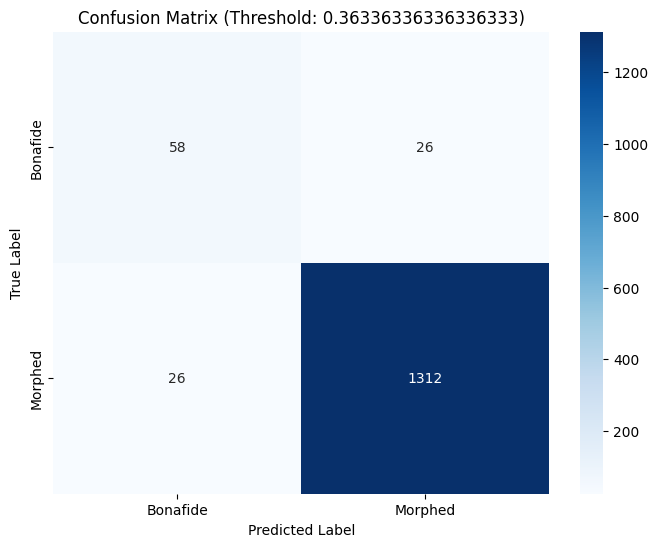


Classification Report:
              precision    recall  f1-score   support

    Bonafide       0.69      0.69      0.69        84
     Morphed       0.98      0.98      0.98      1338

    accuracy                           0.96      1422
   macro avg       0.84      0.84      0.84      1422
weighted avg       0.96      0.96      0.96      1422



In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn.functional as F

def plot_confusion_matrix(model, test_loader, device, threshold=0.5):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            
            # Convert logits to probabilities for the Morph class (index 1)
            probs = F.softmax(outputs, dim=1)[:, 1]
            
            # Apply threshold
            preds = (probs >= threshold).cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plotting
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Bonafide', 'Morphed'], 
                yticklabels=['Bonafide', 'Morphed'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix (Threshold: {threshold})')
    plt.show()

    # Also print the classification report for Precision, Recall, and F1-score
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Bonafide', 'Morphed']))

# Usage:
plot_confusion_matrix(model, test_loader, device, threshold=optimal_th)